# 動画・画像処理レッスン２
## コロイド粒子の検出と秩序変数とかの解析
by 石川晃平(aka konkon)  
e-mail: ishikawa@unno.material.nagoya-u.ac.jp

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import glob

from skimage.feature import peak_local_max
from skimage import data, img_as_float
from scipy import ndimage as ndi
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import KMeans

from tqdm import tqdm_notebook as tqdm

## 画像の読み込み
pythonの標準ライブラリglobを使用。

In [3]:
# ./sample 内のpng画像のパスをすべて取得
path = glob.glob('./sample/*.png')

In [4]:
# すべての画像を取得しリストに保存
images = []
for p in path:
    #グレースケールで読み込み(第2引数を"1"にすると24-bit Colorで読み込み)
    img = cv2.imread(p,0) 
    #リストの末尾に追加
    images.append(img)
images = np.array(images) #numpy arrayに変換

In [5]:
# numpy arrayの次元を表示。
# 250×250ピクセルの画像が11枚入っている。
print(images.shape)

(241, 250, 250)


## 画像の表示

In [6]:
img = images[70]

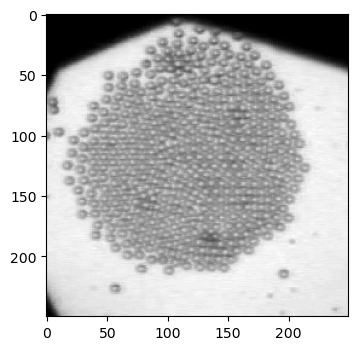

In [7]:
fig = plt.figure(dpi=100) #dpiを指定
plt.gray() #グレースケールで表示
plt.imshow(img)

## 前処理
以下の処理を行う。
* 画像の拡大
* 輝度の正規化
* Non-local mean filterを用いたデノイズ

### 画像の拡大
画像のサイズが縦横二倍になるように拡大

In [8]:
# 画像のサイズを取得。
# hが縦、xが横の大きさ
h,w = img.shape[:2]

# 画像を拡大。
# 元画像のサイズを2倍に拡大。
# 第1引数：拡大元の画像, 第2引数：拡大後の画像サイズ, 第3引数：欠損値の補間法
mag = 2
img = cv2.resize(img,(mag*w,mag*h), interpolation=cv2.INTER_CUBIC)

### 輝度の正規化
画像の輝度を0～255の間で正規化する。
正規化にはmin-max normalizationを用いる。

In [9]:
# 画像を0~1のレンジで正規化する関数
def normalize(img):
    hoge = img.copy()
    max_, min_ = np.max(hoge), np.min(hoge)
    fuga = (hoge - min_)/(max_ - min_)
    return fuga

In [10]:
# 画像の正規化
img_norm = (normalize(img)*255).astype(np.uint8)

### Non-local Mean Filterを使ったデノイズ
(参考：[画像のノイズ除去 — OpenCV-Python Tutorials 1 documentation](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_photo/py_non_local_means/py_non_local_means.html))

In [11]:
# 引数に関しては上のリンクを参照
img_norm = cv2.fastNlMeansDenoising(img_norm,None,7,11,15)

## 正規化・デノイズ前後の画像を比較

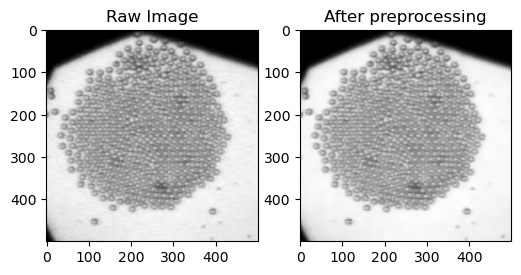

In [12]:
fig = plt.figure(dpi=100)
plt.subplot(121) # 画像をグリッド状に並べるときはこれを使う
plt.title('Raw Image') # これはタイトル
plt.imshow(img)
plt.subplot(122)
plt.title('After preprocessing')
plt.imshow(img_norm)

## 適応的二値化を用いた粒子位置検出

以下の流れで粒子検出を行います

* ガウシアンフィルタを用いた平滑化
* 粒子領域のマスクを作成
* 適応的二値化による粒子領域の候補を選出
* 領域の面積、アスペクト比、Extent、およびマスクを用いたフィルタリング

### ガウシアンフィルタを用いた平滑化

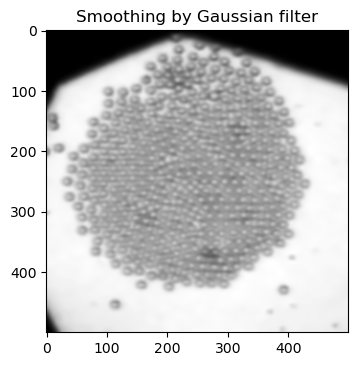

In [13]:
# ガウシアンフィルタの適用
# 第1引数は適用する画像、第2引数はカーネルの大きさ、第3引数は？？？
img_blur = cv2.GaussianBlur(img_norm,(9,9),0)

# 結果を表示
fig = plt.figure(dpi=100)
plt.title('Smoothing by Gaussian filter')
plt.imshow(img_blur)

### 粒子領域のマスクを作成

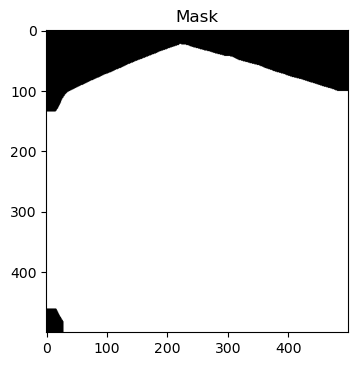

In [14]:
# 二値化(thが閾値)
th = 30
__,mask = cv2.threshold(img_blur,th,255,cv2.THRESH_BINARY)
# モルフォロジー変換(膨張処理)
mask = cv2.erode(mask,np.ones((31,31),np.uint8),iterations = 1)

#結果を表示
fig = plt.figure(dpi=100)
plt.title('Mask')
plt.imshow(mask)

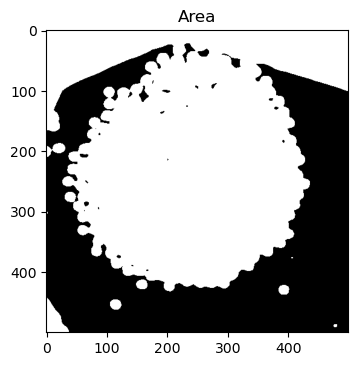

In [15]:
#粒子領域(area)の二値化

__,area = cv2.threshold(img_blur,200,255,cv2.THRESH_BINARY_INV)

fig = plt.figure(dpi=100)
plt.title('Area')
plt.imshow(area)

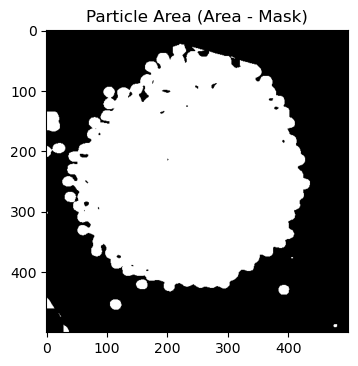

In [16]:
# areaのうち、mask == 0の領域を粒子領域として定義
# この領域に中心が存在する粒子のみをカウントする

area[np.where(mask == 0)] = 0 #これが粒子領域のマスク

fig = plt.figure(dpi=100)
plt.title('Particle Area (Area - Mask)')
plt.imshow(area)

### 適応的二値化による粒子領域の候補選出
OpenCVの適応的二値化処理に関しては以下を見てください。  
(参考：[画像のしきい値処理 — OpenCV-Python Tutorials 1 documentation](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html#id4))  
(参考：[opencv 2.2 documentation - cv::adaptiveThreshold](http://opencv.jp/opencv-2svn/cpp/miscellaneous_image_transformations.html#cv-adaptivethreshold))

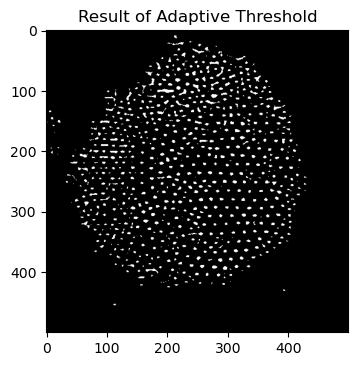

In [17]:
# 適応的二値化処理
# 第1引数は処理対象の画像
# 第2引数はそれ以下の値に二値化を適用する閾値(最大値=255でOK)
# 第3引数は用いるアルゴリズム
# 第4引数は閾値の種類
# 第5引数と第6引数はパラメータ(documentationを参照)
th = cv2.adaptiveThreshold(img_blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,7,-3)

# 結果を表示
fig = plt.figure(dpi=100)
plt.title('Result of Adaptive Threshold')
plt.imshow(th)

### 検出した領域を元画像に重ねて表示
二値化画像からの領域検出にはcv2.findContoursを使用。  
(参考：[輪郭: 初めの一歩 — OpenCV-Python Tutorials 1 documentation](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_contours/py_contours_begin/py_contours_begin.html))  

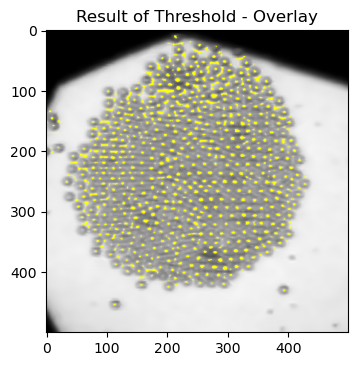

In [18]:
# 領域の検出
# 詳細は上記リンクを見てください。
cnts,__ = cv2.findContours(th,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

# 前バージョンのOpenCVの場合は以下のように
# __,cnts,__ = cv2.findContours(th,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

#検出領域の元画像への書き込み
img_cnts = cv2.cvtColor(img_norm,cv2.COLOR_GRAY2BGR)
img_cnts = cv2.drawContours(img_cnts, cnts, -1, (255,255,0), -1)

#プロット
fig = plt.figure(dpi=100)
plt.title('Result of Threshold - Overlay')
plt.imshow(img_cnts)

### 領域の属性とマスクを用いたフィルタリング

上のように検出した領域は、粒子の中心ではない部分も多く含まれています。  
このような領域を除去するために、領域の属性(アスペクト比etc...)を用いたフィルタリングを行います。  
(参考：[領域(輪郭)の特徴 — OpenCV-Python Tutorials 1 documentation](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_contours/py_contour_features/py_contour_features.html))  
(参考：[領域(輪郭)の属性情報 — OpenCV-Python Tutorials 1 documentation](http://labs.eecs.tottori-u.ac.jp/sd/Member/oyamada/OpenCV/html/py_tutorials/py_imgproc/py_contours/py_contour_properties/py_contour_properties.html))

In [19]:
# このリストに検出結果として粒子の重心(cx,cy)を入れる
pts_filtered = []

for cnt in cnts:
    # モーメントを計算
    M = cv2.moments(cnt)
    if(M['m00'] != 0):
        # 重心を計算
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        # アスペクト比を計算
        x,y,w,h = cv2.boundingRect(cnt)
        aspect_ratio = np.log10(float(w)/h)
        # 面積を計算
        a = float(cv2.contourArea(cnt))
        # Extentを計算
        extent = a /(w*h)
        # フィルタリング
        # このあたりのパラメータはふんいきで変える
        if(aspect_ratio > -0.1 and aspect_ratio < 0.4 and extent > 0.2 and area[cy,cx] != 0 and a > 1):
            pts_filtered.append([cy,cx])
        else:
            pass
    else:
        pass
    
pts_filtered = np.array(pts_filtered).T

## 粒子の検出結果をプロット

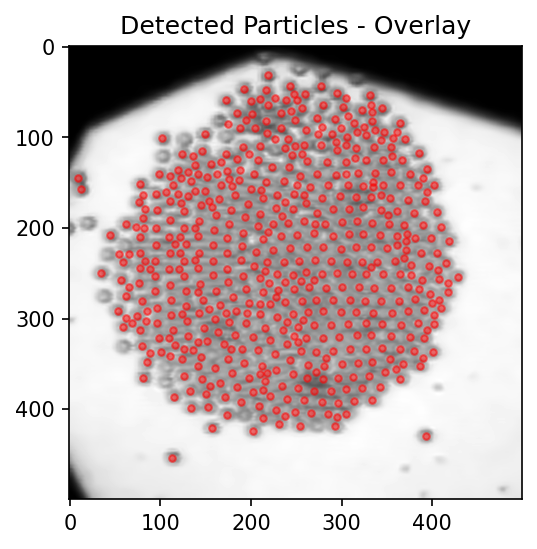

In [20]:
fig = plt.figure(dpi=150)
plt.title('Detected Particles - Overlay')
plt.imshow(img_norm)
plt.scatter(pts_filtered[1],pts_filtered[0],s=10,c='r',alpha=0.5)

## 粒子の二重検出をフィルタリング
検出点間の距離が7px以内の場合、その重心を粒子の代表点とする。  
近傍点の計算にはscikit-learnのNearestNeighborsを用いる。  
(参考：[sklearn.neighbors.NearestNeighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html))

In [21]:
th = 7 #二重検出とする閾値

#sklearnのNearestNeighborでそれぞれの近傍粒子のインデックスと距離を計算
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(pts_filtered.T)
distances, indices = nbrs.kneighbors(pts_filtered.T)

# th以内に近傍が存在する点は、重心を代表点となるようにフィルタリングする
center_list = []
idx_rem = []
for d,i in zip(distances,indices):
    i = i[np.where(d < th)]
    pts = pts_filtered.T[i]
    idx_rem.extend(i[1:])
    if(i[0] not in idx_rem):   
        center = np.median(pts,axis=0)
        center_list.append(center)
center_list = np.array(center_list).astype(np.int32)

#重複を削除
center_list = np.unique(center_list,axis=0)
center_list = center_list.T

### 重複のカウント

In [22]:
print('Detected points:',pts_filtered.T.shape[0])
print('Filtered points:',center_list.T.shape[0])
print('Duplication: ',pts_filtered.T.shape[0]-center_list.T.shape[0])

Detected points: 534
Filtered points: 533
Duplication:  1


## 近接粒子との連結を計算
先ほどと同じくNearest Neighborを用いて計算。

In [23]:
#近傍粒子数の計算
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(center_list.T)
distances, indices = nbrs.kneighbors(center_list.T)

In [24]:
#近接とみなす粒子距離の閾値
th = 22

co_list = [] #近接点の数
connections = [] #近接点の組み合わせ

for d,i in zip(distances,indices):
    idx = i[np.where(d < th)][1:]
    co_list.append(idx.shape[0])
    for j in idx:
        connections.append([center_list.T[i[0]],center_list.T[j]])
        
co_list = np.array(co_list)
connections = np.array(connections)

### 近接粒子数のヒストグラムを表示
細密充填なら6のあたりにピークが来るはず。  
そうならない場合は閾値の設定がおかしいことを疑った方がよい。

(array([  5.,   9.,   4.,  14.,  27.,  50., 153., 129.,  90.,  52.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

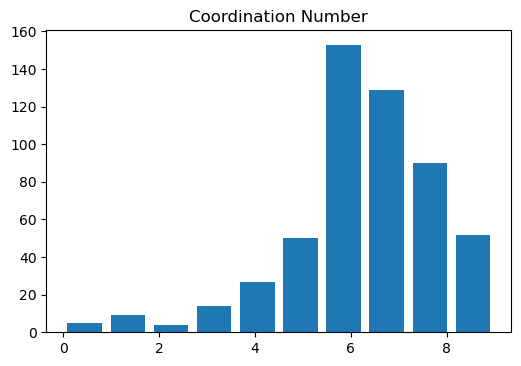

In [25]:
fig = plt.figure(dpi=100)
plt.title('Coordination Number')
plt.hist(co_list,rwidth=0.8)

### 近接粒子間の結合と、近接粒子数をプロット

In [26]:
#カラーマップを作成
co_norm = (co_list/np.max(co_list))*256
co_color = cv2.applyColorMap(co_norm.astype(np.uint8), cv2.COLORMAP_COOL)

In [27]:
#プロットを作成
img_res = cv2.cvtColor(img_norm,cv2.COLOR_GRAY2BGR)

for con in connections:
    img_res = cv2.line(img_res,(con[0][1],con[0][0]),(con[1][1],con[1][0]),(255,255,255),1)
for p_num,cnt in enumerate(center_list.T):
    img_res = cv2.circle(img_res,(cnt[1],cnt[0]),4,tuple([int(x) for x in co_color[p_num][0]]),-1)

img_res = cv2.cvtColor(img_res,cv2.COLOR_BGR2RGB)

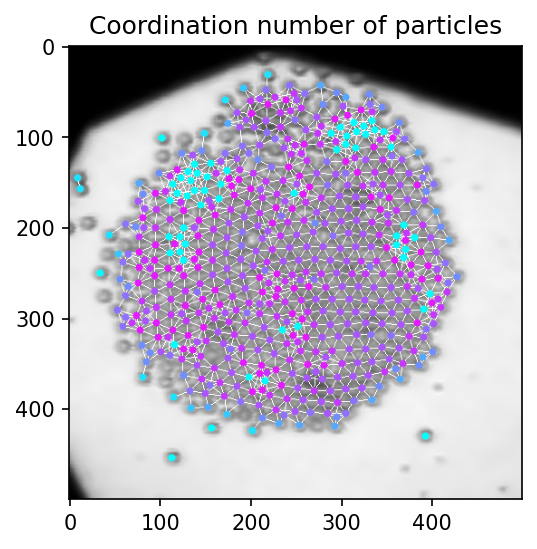

In [28]:
#表示
fig = plt.figure(dpi=150)
plt.title('Coordination number of particles')
plt.imshow(img_res)

## 秩序変数を計算
今回は6-fold symmetryの秩序変数を計算する。

In [29]:
# 極座標系へ変換する関数
def CalcPolarCoordinates(pts):
    pts_polar = np.array([i - pts[0] for i in pts])[1:]
    pts_polar = np.array([[np.sqrt(i[1]**2 + i[0]**2), np.arctan2(i[0],i[1])] for i in pts_polar])
    return pts_polar
    
# オーダーパラメーターを計算する関数
def CalcOrderParam(theta,order):
    num = theta.shape[0]
    cosine = np.sum(np.cos(order*theta)) / num
    sine = np.sum(np.sin(order*theta)) / num
    psi = np.sqrt(cosine**2 + sine**2)
    return psi

In [30]:
#近傍粒子の計算
nbrs = NearestNeighbors(n_neighbors=10, algorithm='ball_tree').fit(center_list.T)
distances, indices = nbrs.kneighbors(center_list.T)

#近傍粒子とみなす閾値
th = 22

#オーダーパラメーターの計算
psi_list = []
for dist,idx in zip(distances,indices):
    pts = center_list.T[idx[np.where(dist < 22)]]
    pts_polar = CalcPolarCoordinates(pts)
    if(pts_polar.shape[0] > 0):
        psi = CalcOrderParam(pts_polar[:,1],6)
    else:
        psi = 0
    psi_list.append(psi)

### プロットの作成

In [31]:
psi_list = np.array(psi_list)*256
psi_color = cv2.applyColorMap(psi_list.astype(np.uint8), cv2.COLORMAP_COOL)

In [32]:
img_res = cv2.cvtColor(img_norm,cv2.COLOR_GRAY2BGR)
for con in connections:
    img_res = cv2.line(img_res,(con[0][1],con[0][0]),(con[1][1],con[1][0]),(255,255,255),1)
for p_num,cnt in enumerate(center_list.T):
    img_res = cv2.circle(img_res,(cnt[1],cnt[0]),4,tuple([int(x) for x in psi_color[p_num][0]]),-1)
img_res = cv2.cvtColor(img_res,cv2.COLOR_BGR2RGB)

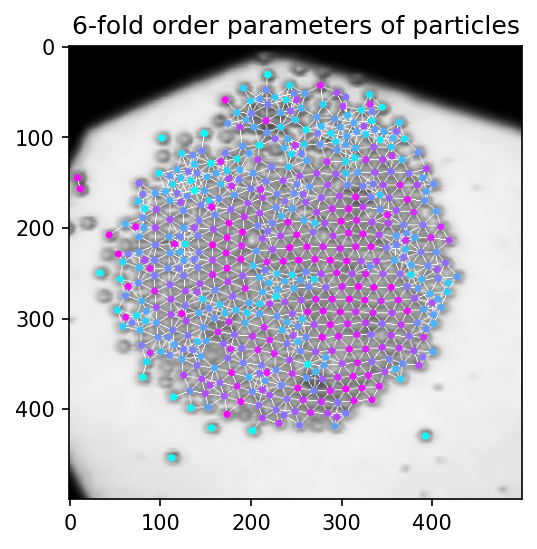

In [33]:
#表示
fig = plt.figure(dpi=150)
plt.title('6-fold order parameters of particles')
plt.imshow(img_res)

## パーシステントホモロジーの計算
以下の部分を計算するときは[Homcloud](http://www.wpi-aimr.tohoku.ac.jp/hiraoka_labo/homcloud/index.html)のインストールが必要です。  
Windowsの場合は以下の通り。がんばってください。  
[Homcloud - Windows 10 64bitマシンでのインストール](http://www.wpi-aimr.tohoku.ac.jp/hiraoka_labo/homcloud/install-guide/install_guide_for_Windows.html)

In [34]:
# インポート
import homcloud.interface as hc
import matplotlib as mpl

In [35]:
# 粒子点が 0 < x < 1, 0 < y < 1 の範囲内になるように調整
pointcloud = center_list.T/(img_norm.shape[:2][0])

In [36]:
# パーシステントホモロジーを計算して結果を保存
hc.PDList.from_alpha_filtration(pointcloud, save_to="pointcloud.idiagram",save_boundary_map=True)
pdlist = hc.PDList("pointcloud.idiagram")
pd1 = pdlist.dth_diagram(1)

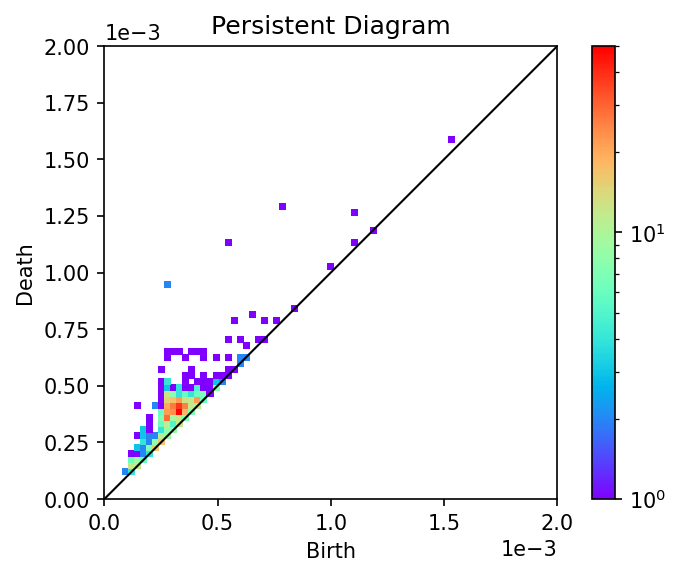

In [37]:
# 作図時のBirth, Deathの描画範囲を設定。
# 最大1,最小0になるが、だいたい粒子間隔の1/2ぐらいのイメージ。
min_,max_ = 0, 2e-3

# パーシステントホモロジーを作図
fig=plt.figure(facecolor='white',dpi=150)
ax = fig.add_subplot(111)
ax.set_aspect('equal', adjustable='box')
H = ax.hist2d(pd1.births, pd1.deaths,bins=75,range=[[min_,max_],[min_,max_]],
              norm=mpl.colors.LogNorm(), cmap="rainbow")
L = ax.plot([0,1], [0,1], c="black", lw=1)
ax.set_xlabel('Birth')
ax.set_ylabel('Death')
ax.set_title('Persistent Diagram')
ax.ticklabel_format(style="sci",axis="y",scilimits=(0,0))
ax.ticklabel_format(style="sci",axis="x",scilimits=(0,0))
plt.xlim(min_,max_)
plt.ylim(min_,max_)
pp = fig.colorbar(H[3],ax=ax)
pp.mappable.set_clim(1,50)